In [3]:
import glob 
from os import path 
from time import perf_counter as clock

from astropy.io import fits
from astropy import units as u
from scipy import ndimage 
import numpy as np

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
  
from mpdaf.obj import Spectrum, Image, WCS, Cube

import matplotlib.pyplot as plt

#def ppxf_example_kinematics_sauron():
ppxf_dir = '/home/nicole/.local/lib/python3.8/site-packages/ppxf' 
data_folder = '/home/nicole/eso325/espectros_binados_voronoi/'
vorbin = np.loadtxt('/home/nicole/eso325/voronoi_bin/Voronoi_Output.txt')

In [4]:
file = data_folder + 'Bin55.fits'    #Nome do arquivo
hdu = fits.open(file)                #Abertura do arquivo #This is the top-level FITS object. When a FITS file is opened, a HDUList object is returned.
gal_lin = hdu[1].data                #Fluxo
h1 = hdu[1].header                   #Header
#print(gal_lin)

noise = np.sqrt(hdu[2].data) # tirando raiz da extensão STAT do arquivo FITS(variância de cada medida), calculando ruído como desvio padrão

lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)]) #define comprimento de onda inicial e final em um array.
FWHM_gal = 2.71  #medida do quanto o telesc. consegue separar 2 linhas de absorção que estão próximas.

wave = np.arange(lamRange1[0], lamRange1[1] + 1.25 , 1.25)

mask = wave < 5600

gal_lin = gal_lin[mask] #novo fluxo mascarado (até 5600A)
wave    = wave[mask]    #novo comprimento de onda mascarado (até 5600A)
noise   = noise[mask]   #novo noise mascarado (até 5600A)

lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(len(gal_lin) - 1)]) #soma do primeiro comp. de onda com o que falta para chegar no último.
print(lamRange1)

galaxy_rebin, logLam1, velscale = util.log_rebin(lamRange1, gal_lin) 
galaxy = galaxy_rebin/np.median(galaxy_rebin)  # Normalize o espectro para evitar problemas numéricos

noise = noise/np.median(galaxy_rebin)

vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30*.fits') #glob.glob lista todos arquivos do template
FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
velscale_ratio = 2  # adopts 2x higher spectral sampling for templates than for galaxy

hdu = fits.open(vazdekis[0])
ssp = hdu[0].data     # Speech Signal Processing module
h2 = hdu[0].header
lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)]) 
sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
templates = np.empty((sspNew.size, len(vazdekis)))

FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2) #piorando templates para ficar parecido com galaxias.
sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

for j, file in enumerate(vazdekis): #j = 149
    hdu = fits.open(file)
    ssp = hdu[0].data
    ssp = ndimage.gaussian_filter1d(ssp, sigma) #degrada template # axis = -1, cval = 0.0, truncate = 4.0
    sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio) 
    templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

c = 299792.458  #Speed of light in km/s
dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s  # dv = -92777.66322243382

z = 0.035  # Initial redshift estimate of the galaxy
goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017) #vel = 449.3517573723122
start = [vel, 200.]  # (km/s), starting guess for [V, sigma] --> com estimativa inicial p/ parâmetros LOSVD
t = clock() #t = 2220.969080546


[4750.17382812 5598.92382812]


 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9975       338    -0.042     0.063
chi2/DOF: 0.9996; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


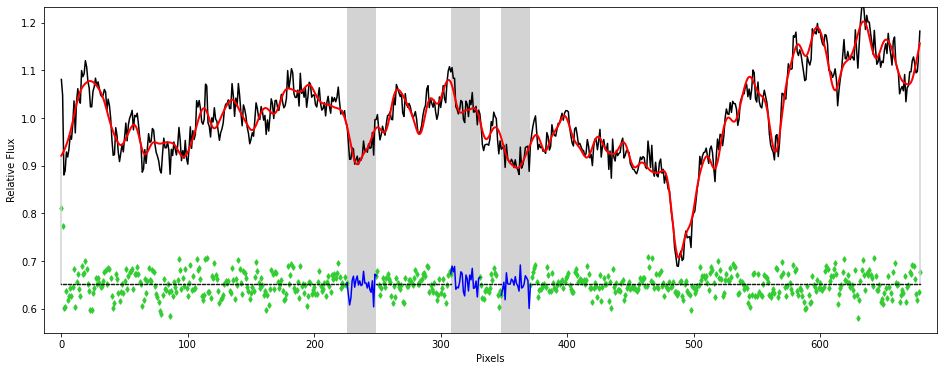

In [5]:
plt.figure(figsize=(16,6))
pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=10, vsyst=dv, velscale_ratio=velscale_ratio) #vsyst --> vel. sistemática da expansão do universo
#chi2 = ideia de quão bom o ajuste está / DOF = grau liberdade  #degree --> melhora ajuste 

In [6]:
for bin_num in range(0,571):
    
    import glob 
    from os import path 
    from time import perf_counter as clock

    from astropy.io import fits
    from astropy import units as u
    from scipy import ndimage 
    import numpy as np

    import ppxf as ppxf_package
    from ppxf.ppxf import ppxf
    import ppxf.ppxf_util as util

    from mpdaf.obj import Spectrum, Image, WCS, Cube

    import matplotlib.pyplot as plt
    
    #file = data_folder + "/Bin%d.fits"%(bin_num)     #Nome do arquivo
    hdu = fits.open(data_folder +"/Bin%d.fits"%bin_num)                #Abertura do arquivo #This is the top-level FITS object. When a FITS file is opened, a HDUList object is returned.
    gal_lin = hdu[1].data                #Fluxo
    h1 = hdu[1].header                   #Header
    #print(gal_lin)
    noise = np.sqrt(hdu[2].data) # tirando raiz da extensão STAT do arquivo FITS(variância de cada medida), calculando ruído como desvio padrão

    lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(h1['NAXIS1'] - 1)]) #define comprimento de onda inicial e final em um array.
    FWHM_gal = 2.71  #medida do quanto o telesc. consegue separar 2 linhas de absorção que estão próximas.

    wave = np.arange(lamRange1[0], lamRange1[1] + 1.25 , 1.25)

    mask = wave < 5600

    gal_lin = gal_lin[mask] #novo fluxo mascarado (até 5600A)
    wave    = wave[mask]    #novo comprimento de onda mascarado (até 5600A)
    noise   = noise[mask]   #novo noise mascarado (até 5600A)

    lamRange1 = h1['CRVAL1'] + np.array([0., h1['CDELT1']*(len(gal_lin) - 1)]) #soma do primeiro comp. de onda com o que falta para chegar no último.

    galaxy_rebin, logLam1, velscale = util.log_rebin(lamRange1, gal_lin) 
    galaxy = galaxy_rebin/np.median(galaxy_rebin)  # Normalize o espectro para evitar problemas numéricos

    noise = noise/np.median(galaxy_rebin)

    vazdekis = glob.glob(ppxf_dir + '/miles_models/Mun1.30*.fits') #glob.glob lista todos arquivos do template
    FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    velscale_ratio = 2  # adopts 2x higher spectral sampling for templates than for galaxy

    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data     # Speech Signal Processing module
    h2 = hdu[0].header
    lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)]) 
    sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio)
    templates = np.empty((sspNew.size, len(vazdekis)))

    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2) #piorando templates para ficar parecido com galaxias.
    sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

    for j, file in enumerate(vazdekis): #j = 149
        hdu = fits.open(file)
        ssp = hdu[0].data
        sspNew = ndimage.gaussian_filter1d(ssp, sigma) #degrada template # axis = -1, cval = 0.0, truncate = 4.0
        sspNew, logLam2, velscale_temp = util.log_rebin(lamRange2, ssp, velscale=velscale/velscale_ratio) 
        templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

    c = 299792.458  #Speed of light in km/s
    dv = (np.mean(logLam2[:velscale_ratio]) - logLam1[0])*c  # km/s  # dv = -92777.66322243382
    
    z = 0.035  # Initial redshift estimate of the galaxy
    goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

    vel = c*np.log(1 + z)   # eq.(8) of Cappellari (2017) #vel = 449.3517573723122
    start = [vel, 200.]  # (km/s), starting guess for [V, sigma] --> com estimativa inicial p/ parâmetros LOSVD
    t = clock() #t = 2220.96908054
 
    pp = ppxf(templates, galaxy, noise, velscale, start,
                  goodpixels=goodPixels, plot=False, moments=4,
                  degree=10, vsyst=dv, velscale_ratio=velscale_ratio)
    
    #sol = [vel, sigma, h3, h4]
        
    vel = pp.sol[0]
    sigma = pp.sol[1]
    h3 = pp.sol[2]
    h4 = pp.sol[3]
    chi2_DOF = pp.chi2
        
    vel_error = pp.error[0]
    sigma_error = pp.error[1]
    h3_error = pp.error[2]
    h4_error = pp.error[3]
    
    newrow = [np.int(bin_num),vel,sigma,h3,h4,chi2_DOF,vel_error,sigma_error,h3_error,h4_error]
    if bin_num == 0:
        table = np.array([np.int(bin_num),vel,sigma,h3,h4,chi2_DOF,vel_error,sigma_error,h3_error,h4_error])
    else:
        table = np.vstack([table,newrow]) #adiciona uma linha na horizontal abaixo da linha acima.

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9999       405     0.001     0.062
chi2/DOF: 0.7313; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150


/tmp/ipykernel_3949/2732117843.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  newrow = [np.int(bin_num),vel,sigma,h3,h4,chi2_DOF,vel_error,sigma_error,h3_error,h4_error]
/tmp/ipykernel_3949/2732117843.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note l

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9997       371     0.017     0.030
chi2/DOF: 0.7097; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9976       357    -0.032    -0.026
chi2/DOF: 0.6499; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9993       384    -0.003     0.010
chi2/DOF: 0.8293; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10003       369     0.021     0.034
chi2/DOF: 0.7788; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_me

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10003       338     0.026     0.016
chi2/DOF: 0.8051; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9987       336     0.012     0.074
chi2/DOF: 0.6978; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10015       358    -0.001     0.039
chi2/DOF: 0.6902; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9983       336    -0.020     0.045
chi2/DOF: 0.9679; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_me

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9971       346     0.030    -0.023
chi2/DOF: 0.7097; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9962       316    -0.034     0.017
chi2/DOF: 1.065; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9973       314    -0.006    -0.024
chi2/DOF: 1.098; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9994       339     0.002     0.005
chi2/DOF: 0.9263; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_meth

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9999       301    -0.027    -0.020
chi2/DOF: 1.467; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9993       306     0.023     0.047
chi2/DOF: 1.465; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10010       322    -0.015     0.079
chi2/DOF: 1.018; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9978       295    -0.033     0.044
chi2/DOF: 1.547; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9971       323     0.025    -0.011
chi2/DOF: 1.324; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9995       299    -0.011     0.043
chi2/DOF: 1.207; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9986       297    -0.020     0.045
chi2/DOF: 1.037; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9985       311    -0.036     0.011
chi2/DOF: 1.132; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10003       284    -0.014     0.063
chi2/DOF: 1.694; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10020       311    -0.003     0.026
chi2/DOF: 1.081; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9986       289    -0.048     0.028
chi2/DOF: 1.621; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9967       280    -0.070     0.023
chi2/DOF: 2.095; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10007       318    -0.050     0.038
chi2/DOF: 1.130; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9990       324    -0.034     0.007
chi2/DOF: 1.075; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10008       334     0.016    -0.000
chi2/DOF: 0.8303; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9990       326    -0.033    -0.004
chi2/DOF: 0.9074; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_meth

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9996       358     0.011    -0.003
chi2/DOF: 0.7647; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9998       302    -0.013     0.048
chi2/DOF: 1.242; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10000       315    -0.113     0.041
chi2/DOF: 2.420; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9994       353    -0.013     0.008
chi2/DOF: 0.8053; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_meth

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9981       286    -0.024     0.014
chi2/DOF: 1.555; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9992       256    -0.084     0.146
chi2/DOF: 5.647; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9978       309    -0.011     0.076
chi2/DOF: 2.439; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9966       297    -0.067     0.001
chi2/DOF: 3.834; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9991       337     0.010     0.046
chi2/DOF: 0.7436; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9989       332     0.006     0.035
chi2/DOF: 0.9946; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9989       345    -0.022     0.010
chi2/DOF: 0.9319; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9988       354     0.002     0.054
chi2/DOF: 0.6930; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_me

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9995       346    -0.020     0.053
chi2/DOF: 0.7268; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9984       274    -0.007     0.127
chi2/DOF: 3.069; degree = 10; mdegree = 0
method = capfit; Jac calls: 9; Func calls: 47; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9982       283    -0.027     0.032
chi2/DOF: 2.053; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9984       292    -0.026     0.081
chi2/DOF: 1.693; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_metho

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10009       320     0.018     0.046
chi2/DOF: 1.527; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9993       306    -0.044     0.056
chi2/DOF: 0.9006; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9979       334    -0.011     0.064
chi2/DOF: 0.9125; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9984       321    -0.049     0.085
chi2/DOF: 1.118; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_meth

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9986       323    -0.019     0.034
chi2/DOF: 1.047; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10005       265    -0.045     0.088
chi2/DOF: 3.342; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9991       306    -0.051     0.056
chi2/DOF: 1.402; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9993       303    -0.062     0.074
chi2/DOF: 1.078; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9970       307    -0.022     0.076
chi2/DOF: 1.828; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9987       275    -0.040     0.058
chi2/DOF: 2.557; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10017       332     0.006     0.021
chi2/DOF: 1.436; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10002       310    -0.027     0.034
chi2/DOF: 0.9503; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_metho

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9999       278    -0.059     0.038
chi2/DOF: 1.604; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9995       336     0.019     0.066
chi2/DOF: 1.339; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9984       299     0.073     0.050
chi2/DOF: 1.893; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10004       318    -0.008     0.019
chi2/DOF: 1.472; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9997       285     0.026     0.020
chi2/DOF: 1.345; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9972       312    -0.016     0.081
chi2/DOF: 1.750; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9997       300    -0.032     0.060
chi2/DOF: 2.028; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9979       320    -0.003     0.046
chi2/DOF: 1.249; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9962       278     0.025     0.039
chi2/DOF: 2.322; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9979       272    -0.086     0.087
chi2/DOF: 3.213; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9973       265    -0.063     0.095
chi2/DOF: 4.467; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9998       287     0.001     0.052
chi2/DOF: 1.609; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9993       281     0.046     0.044
chi2/DOF: 2.168; degree = 10; mdegree = 0
method = capfit; Jac calls: 7; Func calls: 37; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10008       258    -0.015     0.069
chi2/DOF: 1.995; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:     10016       255    -0.006     0.060
chi2/DOF: 4.296; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:      9993       277    -0.038     0.079
chi2/DOF: 4.652; degree = 10; mdegree = 0
method = capfit; Jac calls: 6; Func calls: 32; Status: 2
linear_method

In [7]:
np.savetxt('medidas_espectros_binados_voronoi.txt',table,header= 'bin_num vel sigma h3 h4 chi2_DOF vel_error sigma_error h3_error h4_error', fmt='%i %10e %10e %10e %10e %10e %10e %10e %10e %10e',delimiter=' ') #Salva a tabela